In [1]:
import qutip as qt
import numpy as np
import lmfit as lm
import matplotlib.pyplot as plt
from lmfit import Model
#_ = %precision 3

In [2]:
num_basis = 8
π = np.pi

## Test 1

(1) $\hat{a}_s$: resonator lowering operator

(2) $\omega_s$: resonator resonance frequency

(3) $n^s_{th}$: equilibrium thermal photon population, 

(4) $\kappa_s$: rate associated with spontaneous applications of $\hat{a}_s$, $\hat{a}_s^\dagger$

(5) $n_0$: initial photon population

could investigate further, at this point in time simply take these Lindblad operators for granted

In [3]:
a_s = qt.destroy(num_basis)
w_s = 1
n_s = 2
kappa_s = 0.2
n0 = 1

$H = \omega_s \hat{a}^\dagger_s \hat{a}_s$

$L_- = \sqrt{\kappa_s(1 + n^s_{th})} \hat{a}_s$

$L_+ = \sqrt{\kappa_s n^s_{th}} \hat{a}_s^\dagger$

In [4]:
def hamiltonian(w_s, a_s):
    return w_s * a_s.dag() * a_s

def L_minus(kappa_s, n_s, a_s):
    return np.sqrt(kappa_s * (1 + n_s)) * a_s

def L_plus(kappa_s, n_s, a_s):
    return np.sqrt(kappa_s * n_s) * a_s.dag()

H = hamiltonian(w_s, a_s)
c_ops = [L_minus(kappa_s, n_s, a_s), L_plus(kappa_s, n_s, a_s)]

$|\psi_0\rangle = |n_0\rangle$

$\bar{n}(t)=\langle \hat{a}_s^\dagger \hat{a}_s \rangle(t) = n_0 e^{-t/\tau_s} + n^{s}_{th} (1 - e^{-t/\tau_s})$

In [5]:
psi0 = qt.basis(num_basis, n0)
rho0 = psi0 * psi0.dag()
num = a_s.dag() * a_s

In [6]:
times = np.linspace(0, 20, 501)
result = qt.mesolve(H, rho0, times, c_ops)

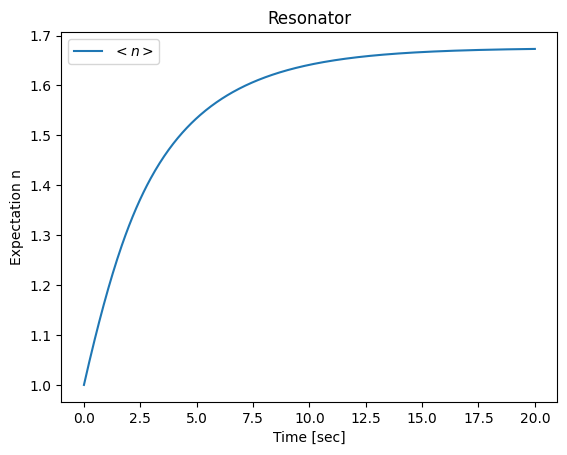

In [7]:
expect_num = []
var_num = []
for state in result.states:
    expect_num.append(qt.expect(num, state))
    var_num.append(qt.variance(num, state))

fig = plt.figure()  
plt.plot(times, expect_num, label='$<n>$')
plt.ylabel('Expectation n')
plt.xlabel('Time [sec]')
plt.title('Resonator')
plt.legend()

In [8]:
def fn(t, n0, tau_s, n_s):
    t1 = n0 * np.exp(-t/tau_s)
    t2 = n_s * (1 - np.exp(-t/tau_s))
    return t1 + t2

model = Model(fn)
params = model.make_params(n0=7, tau_s=1/kappa_s, n_s=n_s)
fit_result = model.fit(expect_num, params, t=times)

In [9]:
print(f"{fit_result.params['n0'].value}, {fit_result.params['tau_s'].value}, {fit_result.params['n_s'].value}")
print(f"{n0}, {1/kappa_s}, {n_s}")

0.99989650142606, 3.1455091640483523, 1.6716132309224747
1, 5.0, 2


In [10]:
fitted_num = fit_result.params['n0'].value * np.exp(-times/fit_result.params['tau_s'].value) + fit_result.params['n_s'].value * (1 - np.exp(-times/fit_result.params['tau_s'].value))

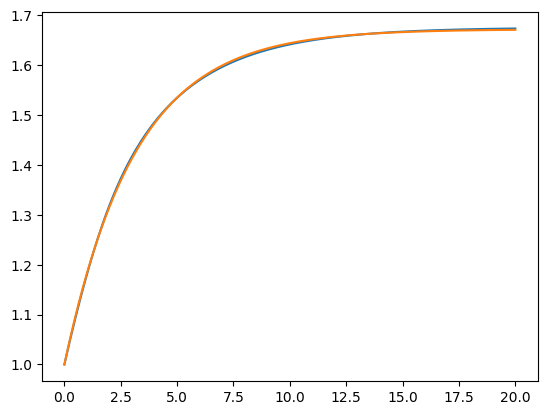

In [11]:
fig = plt.figure()  
plt.plot(times, expect_num, label='$<n>$')
plt.plot(times, fitted_num, label='$<n>$')

Text(0.5, 1.0, 'Compare Fit Result to Simulated Result')

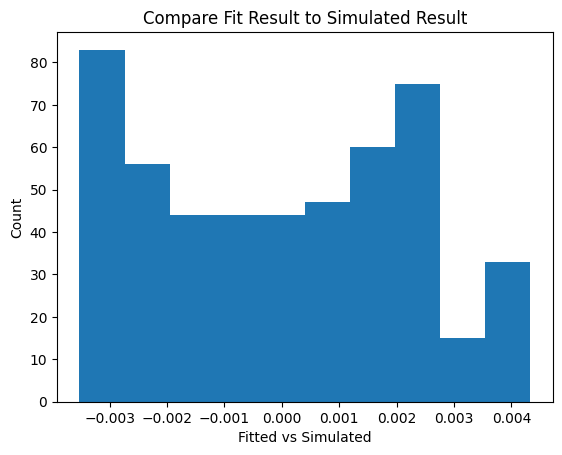

In [12]:
fig = plt.figure()
_ = plt.hist(expect_num-fitted_num)
plt.xlabel('Fitted vs Simulated')
plt.ylabel('Count')
plt.title('Compare Fit Result to Simulated Result')

## Full Hamiltonian

\begin{equation}
\hat{H} = 
(\omega_a - \chi_{sa} \hat{a}^\dagger_s \hat{a}_s) \hat{b}^\dagger \hat{b} + 
(\omega_r - \chi_{ra} \hat{b}^\dagger \hat{b}) \hat{a}^\dagger_r \hat{a}_r + 
(\omega_s - \chi_{sra} \hat{a}^\dagger_r \hat{a}_r) \hat{a}^\dagger_s \hat{a}_s - 
\frac{K_s}{2} \hat{a}^\dagger_s \hat{a}^\dagger_s \hat{a}_s \hat{a}_s -
\frac{K_r}{2} \hat{a}^\dagger_r \hat{a}^\dagger_r \hat{a}_r \hat{a}_r -
\frac{K_a}{2} \hat{b}^\dagger \hat{b}^\dagger \hat{b} \hat{b}
\end{equation}

a--ancilla qubit, r--readout resonator, s--storage resonator

In [13]:
def hamiltonian(omega_a, chi_sa, a_s, omega_r, chi_ra, a_r, omega_s, chi_sra, Ks, Kr, Ka, b):
    t1 = (omega_a - chi_sa * a_s.dag() * a_s) * b.dag() * b
    t2 = (omega_r - chi_ra * b.dag() * b) * a_r.dag() * a_r
    t3 = (omega_s - chi_sra * a_r.dag()) * a_r * a_s.dag() * a_s
    t4 = Ks/2 * a_s.dag()**2 * a_s**2
    t5 = Kr/2 * a_r.dag()**2 * a_r**2
    t6 = Ka/2 * b.dag()**2 * b**2
    
    return t1 + t2 + t3 - t4 - t5 - t6


## Test 2
### Generate CAT States

$|\alpha|^2 = \bar{n} == 2$
(orthogonality of 2cat states)

(1) $\hat{P} = e^{iπ a^\dagger_s a_s}$: photon parity operator

Input into function: alpha, 0/1, 0/1

In [128]:
alpha = 1+1j
fac = 1/(np.sqrt(2))

def parity(a_s):
    return ((1j)*π*a_s.dag()*a_s).expm()

def coherent(alpha):
    return qt.coherent(num_basis, alpha)
    
def cat2(alpha, parity, i):
    fac = 1 / np.sqrt(2)

    t1 = qt.coherent(num_basis, alpha)
    t2 = qt.coherent(num_basis, -alpha)
    t3 = qt.coherent(num_basis, (1j)*alpha)
    t4 = qt.coherent(num_basis, -(1j)*alpha)
    
    if parity==0:
        if i==0:
            return (t1 + t2).unit()
    if parity==0:
        if i==1:
            return (t3 + t4).unit()
    if parity==1:
        if i==0:
            return (t1 - t2).unit()
    if parity==1:
        if i==1:
            return (t3 - t4).unit()
    return null

print(alpha * np.conj(alpha))
psi = qt.coherent(num_basis, alpha)
psi

(2+0j)


Quantum object: dims = [[8], [1]], shape = (8, 1), type = ket
Qobj data =
[[ 0.36787913+0.j        ]
 [ 0.36788175+0.36788175j]
 [ 0.        +0.5202372j ]
 [-0.30045869+0.30045869j]
 [-0.29984957+0.j        ]
 [-0.1356348 -0.1356348j ]
 [ 0.        -0.10422563j]
 [ 0.05112266-0.05112266j]]

In [129]:
par = parity(a_s)

In [130]:
basis1 = cat2(alpha, 0, 0) #+1
basis2 = cat2(alpha, 1, 0) #-1
basis3 = cat2(alpha, 0, 1) #+i
basis4 = cat2(alpha, 1, 1) #-i

In [131]:
print(basis1 == par*basis1)
print(basis2 == -1*par*basis2)
print(basis3 == par*basis3)
print(basis4 == -1*par*basis4)

True
True
True
True


In [138]:
#even parity choice
def cat4(alpha, c0, c1):
    c0p = c0 / np.sqrt(c0**2 + c1**2)
    c1p = c1 / np.sqrt(c0**2 + c1**2)
    
    basis1 = cat2(alpha, 0, 0) #+1
    basis2 = cat2(alpha, 1, 0) #-1
    basis3 = cat2(alpha, 0, 1) #+i
    basis4 = cat2(alpha, 1, 1) #-i
    
    return (c0p*basis1 + c1p*basis3).unit()

In [139]:
cat_0 = cat4(alpha, 1, 1)
cat_1 = a_s*cat_0
cat_2 = a_s*cat_1
cat_3 = a_s*cat_2
cat_4 = a_s*cat_3

print(cat_0 == par*cat_0)
print(cat_1 == -1*par*cat_1)
print(cat_2 == par*cat_2)
print(cat_3 == -1*par*cat_3)

True
True
True
True


In [147]:
#note cat_4 = a_s*cat_3  !=  cat_0, but has even parity
#did I do something wrong?????
cat_4

Quantum object: dims = [[8], [1]], shape = (8, 1), type = ket
Qobj data =
[[-3.09514957]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]

In [148]:
cat_0

Quantum object: dims = [[8], [1]], shape = (8, 1), type = ket
Qobj data =
[[ 0.77513572]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [-0.63179476]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]

## Test 3: Hamiltonian Interaction

2 state qubit, n_states state resonator

\begin{equation}
\hat{H} = 
(\omega_a - \chi_{sa} \hat{a}^\dagger_s \hat{a}_s) \hat{b}^\dagger \hat{b} + 
\omega_s \hat{a}^\dagger_s \hat{a}_s - 
\frac{K_s}{2} \hat{a}^\dagger_s \hat{a}^\dagger_s \hat{a}_s \hat{a}_s
\end{equation}

$|\psi_0\rangle = \frac{1}{2} (|g\rangle+|e\rangle) (|\alpha\rangle+|-\alpha\rangle)$

$t=π/\chi_s$

In [253]:
def hamiltonian(omega_a, omega_s, chi_sa, a_s, b, Ks):
    t1 = (omega_a - chi_sa * a_s.dag() * a_s) * b.dag() * b
    t2 = omega_s * a_s.dag() * a_s
    t4 = Ks/2 * a_s.dag()**2 * a_s**2
    return t1 + t2 - t4
    
a = qt.tensor(qt.qeye(2), qt.destroy(num_basis)) #resonator
adag = a.dag()
b = qt.tensor(qt.destroy(2), qt.qeye(num_basis)) #qubit
bdag = b.dag()

w_a = 0
w_s = 0
chi_sa = 1
Ks = 0

#w_a = 2*π * 6 * 1e6 # 6GHz
#w_s = 2*π * 8 * 1e6 # 8GHz
#chi_sa = 10e6 #Hz
#Ks = 10e3 #Hz

H = hamiltonian(omega_a=w_a, omega_s=w_s, chi_sa=chi_sa, a_s=a, b=b, Ks=Ks)

g_state = qt.basis(2, 0) #dim = 2
e_state = qt.basis(2, 1) #dim = 8

alpha = 1+1j
psi_res = cat2(alpha, 0, 0)

psi_super = 1/np.sqrt(2) * (g_state + e_state)
rho1 = qt.tensor(e_state, cat_0) * qt.tensor(e_state, cat_0).dag()
rho2 = qt.tensor(g_state, cat_0) * qt.tensor(g_state, cat_0).dag()
rho3 = qt.tensor(psi_super, cat_0) * qt.tensor(psi_super, cat_0).dag()

times = np.linspace(0, π/chi_sa, 101)
result1 = qt.mesolve(H, rho1, times, options=qt.Options(nsteps=10000))
result2 = qt.mesolve(H, rho2, times, options=qt.Options(nsteps=10000))
result3 = qt.mesolve(H, rho3, times, options=qt.Options(nsteps=10000))

In [257]:
p2 = qt.tensor(g_state, basis3).proj()
#time dependent projection operators to find the probability amplitude we're missing

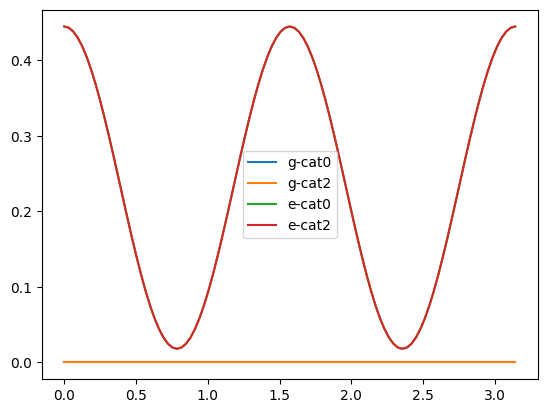

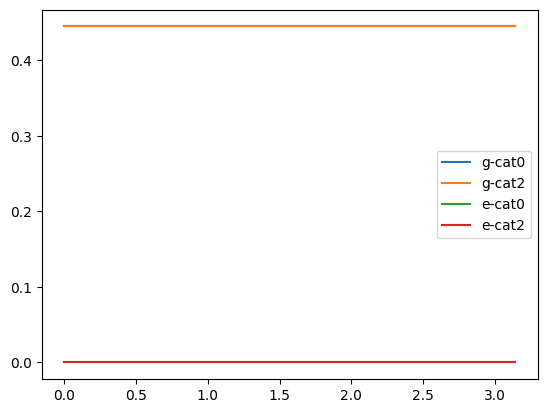

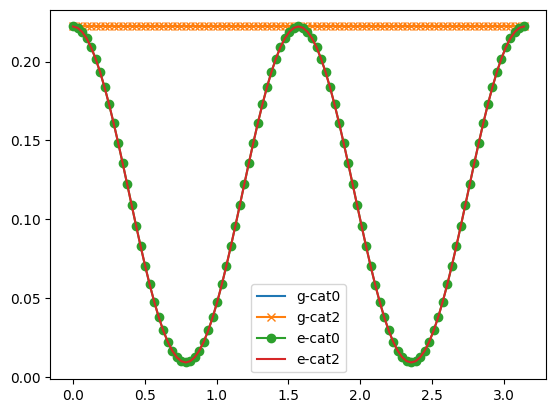

In [252]:
p1 = qt.tensor(g_state, basis1).proj()
p2 = qt.tensor(g_state, basis3).proj()
p3 = qt.tensor(e_state, basis1).proj()
p4 = qt.tensor(e_state, basis3).proj()

#theta=
#U = ((-1j)*(theta)*(adag*a)).expm()
#U*p1*U.dag()

p1s = []
p2s = []
p3s = []
p4s = []
for state in result1.states:
    p1s.append(qt.expect(p1, state))
    p2s.append(qt.expect(p2, state))
    p3s.append(qt.expect(p3, state))
    p4s.append(qt.expect(p4, state))
    
fig = plt.figure()
plt.plot(times, p1s, label='g-cat0')
plt.plot(times, p2s, label='g-cat2')
plt.plot(times, p3s, label='e-cat0')
plt.plot(times, p4s, label='e-cat2')
plt.legend()

#-----------------------

p1s = []
p2s = []
p3s = []
p4s = []
for state in result2.states:
    p1s.append(qt.expect(p1, state))
    p2s.append(qt.expect(p2, state))
    p3s.append(qt.expect(p3, state))
    p4s.append(qt.expect(p4, state))
    
fig = plt.figure()
plt.plot(times, p1s, label='g-cat0')
plt.plot(times, p2s, label='g-cat2')
plt.plot(times, p3s, label='e-cat0')
plt.plot(times, p4s, label='e-cat2')
plt.legend()

#-----------------------

p1s = []
p2s = []
p3s = []
p4s = []
for state in result3.states:
    p1s.append(qt.expect(p1, state))
    p2s.append(qt.expect(p2, state))
    p3s.append(qt.expect(p3, state))
    p4s.append(qt.expect(p4, state))
    
fig = plt.figure()
plt.plot(times, p1s, label='g-cat0')
plt.plot(times, p2s, label='g-cat2', marker='x')
plt.plot(times, p3s, label='e-cat0', marker='o')
plt.plot(times, p4s, label='e-cat2')
plt.legend()

## What does my intuition tell me when I look at these plots??:

1. For the e_state evolution it appears to go through a full cycle at period π/chisa and it seems plausable that by waiting this time we can generate a conditional phase interaction (with respect to the even bloch sphere representation of 2cat states sitting on the poles and 4cat states on the equator)

2. For the g_state evolution it appears to fluctuate in a non-negligable way. It does return to the initial population but it seems unlikely to have not picked up a conditional phase (as is implied in section 5.3.2) --- it does undergo exactly 4 full periods (four applications of the annihilation operator corresponds to the identity (approximately?)) possibly there is no conditional phase for this reason...

Next step- we can test this by probing the phase of the cat state overtime... I imagine we can:

1. retreive the state vector itself and numerically search for the phase relationship to the initial state vector
2. apply pi pulses

I'm going to try 2

### Is this a concern (partial trace)??

In [238]:
e_state * e_state.dag()

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 0.]
 [0. 1.]]

In [239]:
rho1 = qt.tensor(e_state, cat_0) * qt.tensor(e_state, cat_0).dag()
rho1

Quantum object: dims = [[2, 8], [2, 8]], shape = (16, 16), type = oper, isherm = True
Qobj data =
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.         

In [240]:
qt.ptrace(rho1, 0).unit()

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 0.]
 [0. 1.]]

In [241]:
e_state * e_state.dag()

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 0.]
 [0. 1.]]

In [242]:
qt.fidelity(qt.ptrace(rho1, 0), e_state * e_state.dag())

1.0

## If not (continue):

In [243]:
init = rho1
final = result1.states[-1]

print(qt.fidelity(qt.ptrace(init, 0), qt.ptrace(final, 0)))
print(qt.fidelity(qt.ptrace(init, 1), qt.ptrace(final, 1)))
print(qt.fidelity(init, final))

1.0
0.9999716916857891
0.9999716916857891


In [244]:
qt.ptrace(init, 1)

Quantum object: dims = [[8], [8]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[ 0.60083538  0.          0.          0.         -0.48972668  0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [-0.48972668  0.          0.          0.          0.39916462  0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.        ]]

In [245]:
qt.ptrace(final, 1)

Quantum object: dims = [[8], [8]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[ 0.60083538+0.00000000e+00j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.        +0.00000000e+00j
  -0.48966888+2.91608431e-05j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.    

In [246]:
init = rho2
final = result2.states[-1]

print(qt.fidelity(qt.ptrace(init, 0), qt.ptrace(final, 0)))
print(qt.fidelity(qt.ptrace(init, 1), qt.ptrace(final, 1)))
print(qt.fidelity(init, final))

1.0
1.0
1.0


In [247]:
qt.ptrace(init, 1)

Quantum object: dims = [[8], [8]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[ 0.60083538  0.          0.          0.         -0.48972668  0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [-0.48972668  0.          0.          0.          0.39916462  0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.        ]]

In [248]:
qt.ptrace(final, 1)

Quantum object: dims = [[8], [8]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[ 0.60083538  0.          0.          0.         -0.48972668  0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [-0.48972668  0.          0.          0.          0.39916462  0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.        ]]

In [249]:
qt.fidelity(rho1, rho2)

0.0

In [250]:
qt.fidelity(rho1, rho3)

0.7071067848685735

## Relative Phase

In [234]:
state = e_state*np.exp(1j*π/2)
np.angle(state.dag() * e_state)[0][0]

-1.5707963267948966

In [167]:
qt.ptrace(init, 1).dag()*qt.ptrace(final, 1)

Quantum object: dims = [[8], [8]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[ 0.60083538  0.          0.          0.         -0.48972668  0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [-0.48972668  0.          0.          0.          0.39916462  0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.        ]]

In [168]:
np.angle((init.dag()*final).full()[0][0])

0.0

## π Pulses

In [169]:
from qutip.qip.operations import rotation
sx = qt.sigmax()
sy = qt.sigmay()
sz = qt.sigmaz()

pp = rotation(sy, π/2) #π/2 pulse

## QEC Protocol

$\alpha(t)=\alpha e^{-\kappa_st/2}$ (can be investigated further)



## Side Pursuit: Bloch sphere representation of a CAT state